In [1]:
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import re
import numpy as np
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.losses import mean_squared_error

In [4]:
%cd /content/drive/MyDrive/703_Project/LSTM/

/content/drive/MyDrive/703_Project/LSTM


**Create combined csv files**





In [ ]:
"""
def process_folder(main_folder_path, group_label):
   Traite tous les fichiers CSV dans un dossier et retourne un DataFrame fusionné.
    frames = []  # Liste pour stocker les DataFrames de chaque fichier
    for subdir, dirs, files in os.walk(main_folder_path):
      for filename in files:
        if filename.endswith('.csv'):
            file_path = os.path.join(subdir, filename)
            df = pd.read_csv(file_path)
            df['conversation_id'] = filename.split('.')[0]  # Utilisez le nom du fichier comme ID
            df['group'] = group_label
            df = df[['text', 'conversation_id', 'group']]
            frames.append(df)
    return pd.concat(frames)

# Chemins des dossiers pour les fichiers CSV des groupes contrôle et patient
control_main_folder_path = "Control_csv_data_clean"
patient_main_folder_path = "Patient_csv_data_clean"

# Traitement des dossiers et fusion des DataFrames
control_df = process_folder(control_main_folder_path, 'control')
patient_df = process_folder(patient_main_folder_path, 'patient')
combined_df = pd.concat([control_df, patient_df])

# Enregistrement du DataFrame fusionné dans un nouveau fichier CSV
combined_df.to_csv('combined_control_patient_data.csv', index=False)
"""

**Step 1 : data split and preprocessing**

In [8]:
# Charger les données
data = pd.read_csv('combined_control_patient_data.csv')
data_df = pd.DataFrame(data)

# Fonction de nettoyage des données textuelles
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9']", " ", text)  # Supprimer les caractères non alphanumériques
    text = re.sub(r"\s+", " ", text)  # Supprimer les espaces supplémentaires
    return text

# Nettoyage du texte
data_df['text'] = data_df['text'].apply(clean_text)


# Fonction pour calculer le score de sentiment
def sentiment_score(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Retourne un score entre -1 et 1

# Appliquer la fonction à chaque réponse
data_df['sentiment'] = data_df['text'].apply(sentiment_score)

# Groupement des données par conversation_id
conversation_ids = data['conversation_id'].unique()
np.random.shuffle(conversation_ids)

# Division des identifiants de conversation
train_size = int(0.8 * len(conversation_ids))
val_size = int(0.1 * len(conversation_ids))

train_ids = conversation_ids[:train_size]
val_ids = conversation_ids[train_size:train_size + val_size]
test_ids = conversation_ids[train_size + val_size:]

# Sélection des ensembles d'entraînement, de validation et de test
train_df = data[data['conversation_id'].isin(train_ids)]
val_df = data[data['conversation_id'].isin(val_ids)]
test_df = data[data['conversation_id'].isin(test_ids)]

# Tokenisation et Padding
tokenizer = Tokenizer(num_words=12385)
tokenizer.fit_on_texts(data['text'])

# Fonction pour tokeniser et pad un DataFrame
max_seq_length = 15
def prepare_data(df):
    sequences = tokenizer.texts_to_sequences(df['text'])
    return pad_sequences(sequences, maxlen=max_seq_length)

# Préparation des données
X_train_padded = prepare_data(train_df)
y_train = train_df['sentiment'].values

X_val_padded = prepare_data(val_df)
y_val = val_df['sentiment'].values

X_test_padded = prepare_data(test_df)
y_test = test_df['sentiment'].values



In [ ]:
"""
data_sample_df['text'] = data_sample_df['text'].apply(clean_text)
sample_sequences = tokenizer.texts_to_sequences(data_sample_df['text'])
sample_padded = pad_sequences(sample_sequences, maxlen=max_seq_length)
"""

In [ ]:
"""
# examiner les séquences tokenisées et les longueurs de séquence
for i in range(5):
    print(f"Texte original: {data['text'].iloc[i]}")
    print(f"Séquence tokenisée: {sequences[i]}")
    print(f"Longueur de la séquence: {len(sequences[i])}\n")
"""

**How to get num_words and max_seq_length**

In [6]:
# Tokenizer sans limiter le nombre de mots
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_df['text'])

# Nombre total de mots uniques
word_count = len(tokenizer.word_index)
print(f"Nombre total de mots uniques dans le jeu de données : {word_count}")

Nombre total de mots uniques dans le jeu de données : 12385


In [7]:
text_lengths = [len(text.split()) for text in data_df['text']]
print(f"Moyenne: {np.mean(text_lengths)}")
print(f"Médiane: {np.median(text_lengths)}")
print(f"Percentile 90: {np.percentile(text_lengths, 90)}")

Moyenne: 7.460360360360361
Médiane: 6.0
Percentile 90: 15.0


**Verifications**

In [9]:
# Vérification des dimensions pour l'entraînement du modèle

print(f"Dimensions de X_train_padded: {X_train_padded.shape}")
print(f"Dimensions de y_train: {y_train.shape}")
print(f"Dimensions de X_test_padded: {X_test_padded.shape}")
print(f"Dimensions de y_test: {y_test.shape}")
print(f"Dimensions de X_val_padded: {X_val_padded.shape}")
print(f"Dimensions de y_val: {y_val.shape}")

Dimensions de X_train_padded: (64169, 15)
Dimensions de y_train: (64169,)
Dimensions de X_test_padded: (8008, 15)
Dimensions de y_test: (8008,)
Dimensions de X_val_padded: (6633, 15)
Dimensions de y_val: (6633,)


In [10]:
print(f"Dimensions de ids_train: {train_ids.shape}")
print(f"Dimensions de ids_val: {val_ids.shape}")
print(f"Dimensions de ids_test: {test_ids.shape}")

Dimensions de ids_train: (357,)
Dimensions de ids_val: (44,)
Dimensions de ids_test: (46,)


**Step 2 : Word Embeddings preparation**

In [11]:
# Chargement des embeddings GloVe
EMBEDDING_DIM = 100  # Par exemple, pour GloVe 6B avec des vecteurs de 100 dimensions
embedding_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Préparation de la matrice d'embedding
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Création de la couche d'embedding en utilisant la matrice d'embedding
embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_seq_length,
                            trainable=False)

In [12]:
#contrôler la matrice d'embedding
print("Dimensions de la matrice d'embedding:", embedding_matrix.shape)

Dimensions de la matrice d'embedding: (12386, 100)


**Verifications**

In [ ]:
# Tokenizer Vocabulary
for word, index in tokenizer.word_index.items():
    print(f"Mot : {word}, Index : {index}")
    if index == 100:  # Afficher les 10 premiers mots
        break


In [ ]:
# Correspondence in the Embedding Matrix
for word, index in tokenizer.word_index.items():
    if word in embedding_index:
        print(f"Le mot '{word}' est dans GloVe.")
    else:
        print(f"Le mot '{word}' n'est pas dans GloVe.")
    if index == 100:  # Vérifier pour les 10 premiers mots
        break


In [14]:
# Coverage %
total_mots = len(tokenizer.word_index)
mots_dans_glove = sum(1 for word in tokenizer.word_index if word in embedding_index)
pourcentage_couverture = (mots_dans_glove / total_mots) * 100
print(f"Pourcentage de mots du tokeniseur couverts par GloVe : {pourcentage_couverture}%")


Pourcentage de mots du tokeniseur couverts par GloVe : 89.01897456600727%


**Step 3 : LSTM model**

In [16]:
# Création du modèle LSTM
model = Sequential()
model.add(embedding_layer)  # Utilisez la couche d'embedding préparée précédemment
model.add(LSTM(128, return_sequences=False))  # return_sequences=False pour la dernière couche LSTM
model.add(Dropout(0.3))
model.add(Dense(1, activation='tanh'))  # Score de sentiment entre -1 et 1

model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
"""
grouped = data.groupby('conversation_id')  # Groupez par ID de conversation
X = []

for _, group in grouped:
    # Tokenisez et paddez chaque réponse dans la conversation
    sequences = tokenizer.texts_to_sequences(group['text'])
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_length)
    X.append(padded_sequences)

y = []

for _, group in grouped:
    sentiment_scores = group['sentiment'].values  # Scores de sentiment pour la conversation
    y.append(sentiment_scores)

print(y)
"""

**Step 4 : Model training**

In [17]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Entraînement du modèle avec Early Stopping
model.fit(X_train_padded, y_train, epochs=25, batch_size=64, validation_data=(X_val_padded, y_val), callbacks=[early_stopping])
# results --> good behavior, good performance

Epoch 1/25
1003/1003 [==============================] - 50s 46ms/step - loss: 0.0306 - val_loss: 0.0177
Epoch 2/25
1003/1003 [==============================] - 41s 41ms/step - loss: 0.0183 - val_loss: 0.0130
Epoch 3/25
1003/1003 [==============================] - 43s 43ms/step - loss: 0.0145 - val_loss: 0.0105
Epoch 4/25
1003/1003 [==============================] - 46s 46ms/step - loss: 0.0117 - val_loss: 0.0085
Epoch 5/25
1003/1003 [==============================] - 42s 42ms/step - loss: 0.0100 - val_loss: 0.0076
Epoch 6/25
1003/1003 [==============================] - 44s 43ms/step - loss: 0.0087 - val_loss: 0.0067
Epoch 7/25
1003/1003 [==============================] - 41s 41ms/step - loss: 0.0078 - val_loss: 0.0063
Epoch 8/25
1003/1003 [==============================] - 41s 41ms/step - loss: 0.0071 - val_loss: 0.0061
Epoch 9/25
1003/1003 [==============================] - 41s 41ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 10/25
1003/1003 [==============================] - 41s 41m

**Step 5 : Model evaluation**

In [18]:
# Évaluation du Modèle sur l'Ensemble de Test
test_loss = model.evaluate(X_test_padded, y_test)
print(f"Perte sur l'ensemble de test: {test_loss}")


251/251 [==============================] - 4s 16ms/step - loss: 0.0053
Perte sur l'ensemble de test: 0.005294329486787319


In [19]:
# Prédiction des Sentiments sur l'Ensemble de Test
pred_sentiment = model.predict(X_test_padded)

251/251 [==============================] - 4s 15ms/step


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcul des métriques de régression
mse = mean_squared_error(y_test, pred_sentiment)
mae = mean_absolute_error(y_test, pred_sentiment)
rmse = np.sqrt(mse)

print(f"MSE(Mean Squared Error): {mse}, MAE(Mean Absolute Error): {mae}, RMSE(Root Mean Squared Error): {rmse}")
#low MSE --> the model, on average, predicts values ​​quite close to the actual values.
#low MAE --> low average error per prediction
#low RMSE --> low dispersion of errors in the model predictions
#the model gives relatively accurate predictions with low errors on the test set.


MSE(Mean Squared Error): 0.0052943295501708815, MAE(Mean Absolute Error): 0.030618040599591684, RMSE(Root Mean Squared Error): 0.0727621436611847


**Contextualization**

In [21]:
# Calcul de l'écart-type des scores de sentiment réels
ecart_type_sentiment = np.std(data_df['sentiment'])
print(f"Écart-type des scores de sentiment réels: {ecart_type_sentiment}")

# Moyenne absolue des scores de sentiment réels
moyenne_absolue_sentiment = np.mean(np.abs(data_df['sentiment']))
print(f"Moyenne absolue des scores de sentiment réels: {moyenne_absolue_sentiment}")

Écart-type des scores de sentiment réels: 0.2202848557326425
Moyenne absolue des scores de sentiment réels: 0.10087772460610742


In [22]:

# Comparaison de l'RMSE avec l'écart-type
print(f"Le RMSE représente {(rmse / ecart_type_sentiment) * 100:.2f}% de l'écart-type des scores réels.")
# the errors of your sentiment prediction model are quite significant compared to the variability of the real data

Le RMSE représente 33.03% de l'écart-type des scores réels.


In [23]:
#Comparaison du MSE avec l'écart-type
print(f"Le MSE représente {(mse / ecart_type_sentiment**2) * 100:.2f}% de la variance des scores réels.")
# a small part of the variability in sentiment scores is due to your model's prediction errors --> the model is quite precise

# Comparaison du MAE avec la moyenne absolue
print(f"Le MAE représente {(mae / moyenne_absolue_sentiment) * 100:.2f}% de la moyenne absolue des scores réels.")
# the prediction errors, on average, are quite significant compared to the average deviation of the actual scores



Le MSE représente 10.91% de la variance des scores réels.
Le MAE représente 30.35% de la moyenne absolue des scores réels.


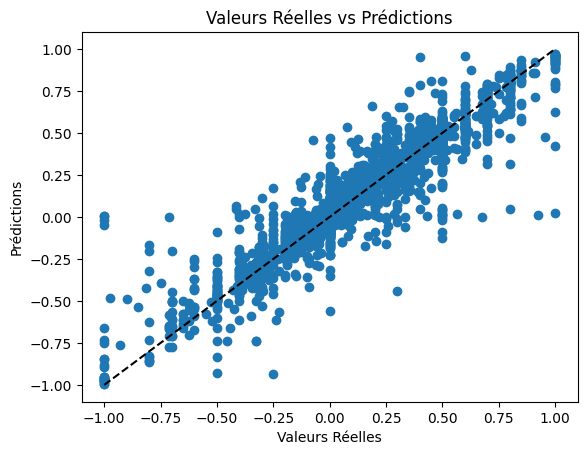

In [33]:
# Graphique de dispersion
plt.scatter(y_test, pred_sentiment)
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title('Valeurs Réelles vs Prédictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # Ligne idéale
plt.show()

**Step 6 : Results**

In [24]:
# Créer un DataFrame pour associer les prédictions aux conversations
test_df['predicted_sentiment'] = pred_sentiment.flatten()

# Grouper par conversation_id
conversations = test_df.groupby('conversation_id')
evolution_sentiments = {}

for conversation_id, group in conversations:
    sentiment_debut = group['predicted_sentiment'].iloc[0]
    sentiment_fin = group['predicted_sentiment'].iloc[-1]
    evolution_sentiments[conversation_id] = sentiment_fin - sentiment_debut

evolutions_patient = [evolution_sentiments[cid] for cid, group in conversations if group['group'].iloc[0] == 'patient']
evolutions_control = [evolution_sentiments[cid] for cid, group in conversations if group['group'].iloc[0] == 'control']

<ipython-input-24-d6b5f769083e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_sentiment'] = pred_sentiment.flatten()


In [ ]:
test_df.columns

Index(['text', 'conversation_id', 'group', 'sentiment', 'predicted_sentiment'], dtype='object')

In [25]:
test_df.to_csv('test_df.csv', index="False")

**Variation totale du sentiment**

In [26]:
# Initialisation des variables pour accumuler les variations
variation_totale = {}
variation_totale_patient = []
variation_totale_controle = []
nombre_conversations_patient = 0
nombre_conversations_controle = 0

for conversation_id, group in conversations:
    # Calcul de la variation du sentiment pour la conversation
    variation = group['predicted_sentiment'].iloc[-1] - group['predicted_sentiment'].iloc[0]
    variation_totale[conversation_id] = variation

    # Compter le nombre de conversations pour chaque groupe
    if group['group'].iloc[0] == 'patient':
        nombre_conversations_patient += 1
        variation_totale_patient.append(variation)
    elif group['group'].iloc[0] == 'control':
        nombre_conversations_controle += 1
        variation_totale_controle.append(variation)

# Calcul des moyennes
moyenne_variation_patient = np.mean(variation_totale_patient)
moyenne_variation_controle = np.mean(variation_totale_controle)

print(f"Moyenne de la variation pour les patients: {moyenne_variation_patient}")
print(f"Moyenne de la variation pour les contrôles: {moyenne_variation_controle}")

print("Variations Totales par Conversation:", variation_totale)
print("Nombre de Conversations - Patient:", nombre_conversations_patient)
print("Nombre de Conversations - Control:", nombre_conversations_controle)



Moyenne de la variation pour les patients: -0.06101858988404274
Moyenne de la variation pour les contrôles: -0.012604392133653164
Variations Totales par Conversation: {'50-2': -0.68857914, '52-1': -0.8753988, '59-2': -0.004056436, '67-2': 0.17077458, 'Baycrest10631a': -0.36305204, 'Baycrest11841a': 0.5076356, 'Baycrest12269a': 0.0, 'Baycrest8673a': -0.86250305, 'MSUC02b': 0.008760994, 'MSUC06b': -0.018416546, 'UMD05': -0.1446932, 'adler01a': -0.054357287, 'adler02a': 0.6527903, 'adler08a': 0.50215644, 'adler10a': -0.4988495, 'adler25a': 0.0012675836, 'kurland02a': 0.47068745, 'kurland02d': -0.5120405, 'kurland02f': -0.08717193, 'kurland09b': 0.0, 'kurland12b': 0.9146751, 'kurland12d': 0.5120141, 'kurland16d': -0.0015756842, 'kurland21d': 0.60288423, 'kurland26a': -0.47567627, 'kurland26b': -0.018146103, 'kurland26d': -0.36772582, 'kurland27c': -0.50457656, 'kurland27d': 0.5422316, 'scale05b': 0.47245765, 'scale06d': -0.2734636, 'scale16a': 0.04531096, 'scale34a': -0.47888336, 'tucson06

**Visualisation graphique**

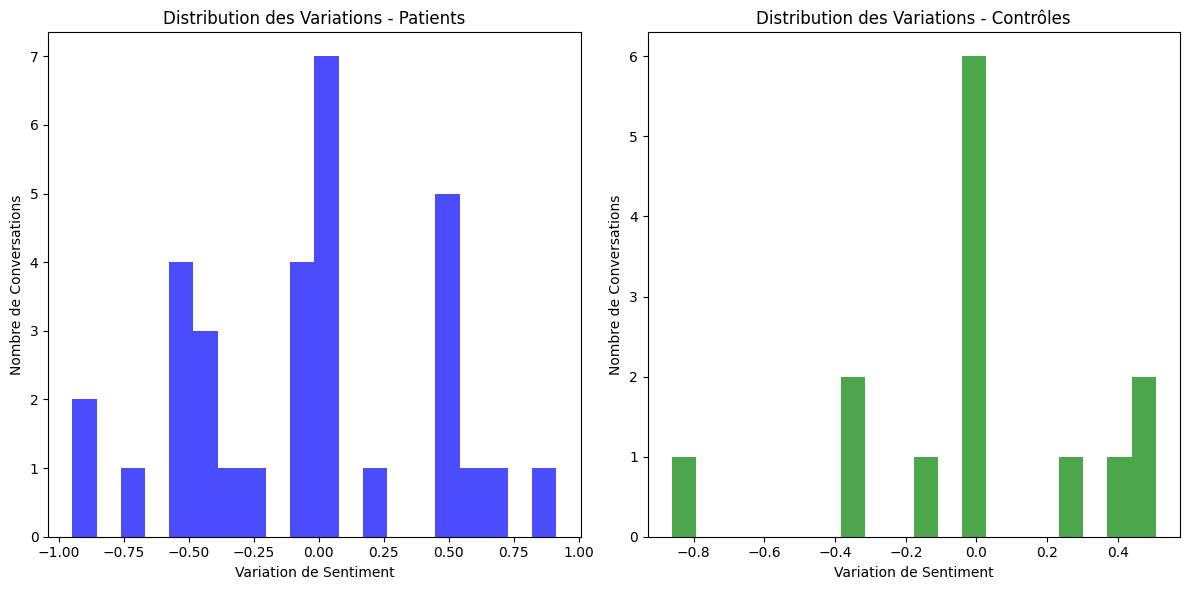

In [27]:
import matplotlib.pyplot as plt

# Histogramme des variations de sentiment
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(variation_totale_patient, bins=20, color='blue', alpha=0.7)
plt.title("Distribution des Variations - Patients")
plt.xlabel("Variation de Sentiment")
plt.ylabel("Nombre de Conversations")

plt.subplot(1, 2, 2)
plt.hist(variation_totale_controle, bins=20, color='green', alpha=0.7)
plt.title("Distribution des Variations - Contrôles")
plt.xlabel("Variation de Sentiment")
plt.ylabel("Nombre de Conversations")

plt.tight_layout()
plt.show()

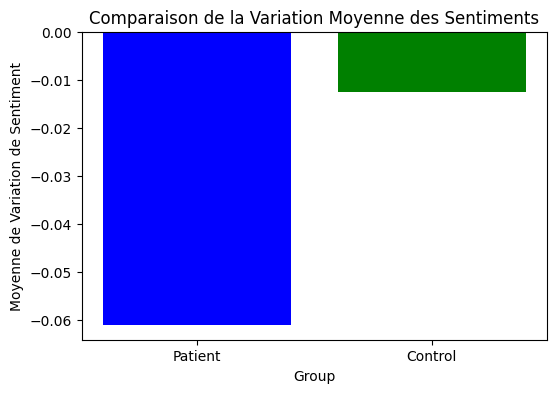

In [28]:
# Comparaison des moyennes des variations
plt.figure(figsize=(6, 4))
groupes = ['Patient', 'Control']
moyennes = [moyenne_variation_patient, moyenne_variation_controle]

plt.bar(groupes, moyennes, color=['blue', 'green'])
plt.xlabel('Group')
plt.ylabel('Moyenne de Variation de Sentiment')
plt.title('Comparaison de la Variation Moyenne des Sentiments')
plt.show()


**Static analysis**

In [ ]:
#variation_patient_sqrt = np.sqrt(np.array(variation_totale_patient) + 1)


In [ ]:

#shapiro_test_patient_transformed = stats.shapiro(variation_patient_sqrt)  # Ou variation_patient_box_cox, variation_patient_sqrt
#print(f"Shapiro Test après transformation: Statistique={shapiro_test_patient_transformed[0]}, p-value={shapiro_test_patient_transformed[1]}")


Shapiro Test après transformation: Statistique=0.9239652156829834, p-value=0.038470104336738586


In [29]:
# check the normality
import scipy.stats as stats

# Test de Shapiro-Wilk pour vérifier la normalité
# Pour le groupe patient
shapiro_test_patient = stats.shapiro(variation_totale_patient)
print(f"Shapiro Test pour le groupe patient: Statistique={shapiro_test_patient[0]}, p-value={shapiro_test_patient[1]}")

# Pour le groupe contrôle
shapiro_test_controle = stats.shapiro(variation_totale_controle)
print(f"Shapiro Test pour le groupe contrôle: Statistique={shapiro_test_controle[0]}, p-value={shapiro_test_controle[1]}")


Shapiro Test pour le groupe patient: Statistique=0.9580698013305664, p-value=0.24303635954856873
Shapiro Test pour le groupe contrôle: Statistique=0.9200807809829712, p-value=0.22048410773277283


In [30]:
#check the homogeneity of variances
from scipy.stats import levene

# Test de Levene pour vérifier l'homogénéité des variances
stat, p_value = levene(variation_totale_patient, variation_totale_controle)

print(f"Test de Levene: Statistique={stat}, p-value={p_value}")

# variances are equal

Test de Levene: Statistique=2.0110756020576916, p-value=0.16319854641913137


In [31]:
from scipy.stats import ttest_ind

# Effectuer un test t pour échantillons indépendants
t_stat, p_value = ttest_ind(variation_totale_patient, variation_totale_controle)

print(f"Test t pour échantillons indépendants: Statistique t={t_stat}, p-value={p_value}")

#p-value > 0.05 --> the difference between the means of the two groups is not statistically significant


Test t pour échantillons indépendants: Statistique t=-0.3431624693597588, p-value=0.7331104792241796


Test de Mann-Whitney U

In [32]:
from scipy.stats import mannwhitneyu

# Effectuer le test de Mann-Whitney U
u_statistic, p_value = mannwhitneyu(variation_totale_patient, variation_totale_controle, alternative='two-sided')

print(f"Test de Mann-Whitney U: U Statistique={u_statistic}, p-value={p_value}")
#-->  p-value pas de différence statistique significative entre les deux groupes

Test de Mann-Whitney U: U Statistique=210.5, p-value=0.7562906382855821
